# Proyek Klasifikasi Gambar: [Weather Image Dataset]
- **Nama:** Azizah Nur Apriliani
- **Email:** azizahprln@gmail.com
- **ID Dicoding:** M891D5X0328

## Import Semua Packages/Library yang Digunakan

In [1]:
!pip install tensorflowjs

In [11]:
import zipfile
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflowjs as tfjs
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers

## Data Preparation

### Data Loading

In [4]:
# Hubungkan Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# lokasi file ZIP dan folder ekstraksi
file_zip = '/content/drive/MyDrive/klasifikasi/Weather-Image-Dataset.zip'
output_dir = '/content/WeatherData'

# Ekstraksi file ZIP
with zipfile.ZipFile(file_zip, mode='r') as archive:
    archive.extractall(path=output_dir)

# Tampilkan daftar isi folder hasil ekstraksi
print("Isi folder hasil ekstraksi:")
print(os.listdir(output_dir))

Mounted at /content/drive
Isi folder hasil ekstraksi:
['foggy', 'sandstorm', 'sunrise', 'rainbow', 'rainy', 'rime', 'cloudy', 'lightning']


### Data Preprocessing

#### Split Dataset

In [5]:
base_dir = "/content/WeatherData"

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_gen = datagen.flow_from_directory(
    base_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    seed=123
)

val_test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.5)

val_gen = val_test_datagen.flow_from_directory(
    base_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    seed=123
)

test_gen = val_test_datagen.flow_from_directory(
    base_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    seed=123
)

Found 2495 images belonging to 8 classes.
Found 1559 images belonging to 8 classes.
Found 1557 images belonging to 8 classes.


## Modelling

In [6]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(train_gen.num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,829,384 (18.42 MB)

 Trainable params: 4,829,384 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True
    ),

    ModelCheckpoint(
        filepath='/content/best_model.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),

    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=2,
        min_lr=1e-5,
        verbose=1
    )
]

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,
    callbacks=callbacks
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2997 - loss: 1.8661
Epoch 1: val_accuracy improved from -inf to 0.68762, saving model to /content/best_model.keras
78/78 ━━━━━━━━━━━━━━━━━━━━ 165s 2s/step - accuracy: 0.3012 - loss: 1.8621 - val_accuracy: 0.6876 - val_loss: 0.9563 - learning_rate: 0.0010
Epoch 2/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5894 - loss: 1.1654
Epoch 2: val_accuracy improved from 0.68762 to 0.72226, saving model to /content/best_model.keras
78/78 ━━━━━━━━━━━━━━━━━━━━ 156s 2s/step - accuracy: 0.5898 - loss: 1.1644 - val_accuracy: 0.7223 - val_loss: 0.8011 - learning_rate: 0.0010
Epoch 3/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6680 - loss: 0.9228
Epoch 3: val_accuracy improved from 0.72226 to 0.74343, saving model to /content/best_model.keras
78/78 ━━━━━━━━━━━━━━━━━━━━ 135s 2s/step - accuracy: 0.6683 - loss: 0.9223 - val_accuracy: 0.7434 - val_loss: 0.7039 - learning_rate: 0.0010
Epoch 4/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s

## Evaluasi dan Visualisasi

In [8]:
# load model terbaik yang sudah disimpan sebelumnya
best_model = load_model('best_model.keras')

train_loss, train_acc = best_model.evaluate(train_gen, verbose=0)
test_loss, test_acc = best_model.evaluate(test_gen, verbose=0)

print(f"Train Accuracy: {train_acc*100:.2f}%")
print(f"Test Accuracy: {test_acc*100:.2f}%")

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Train Accuracy: 99.80%
Test Accuracy: 93.38%


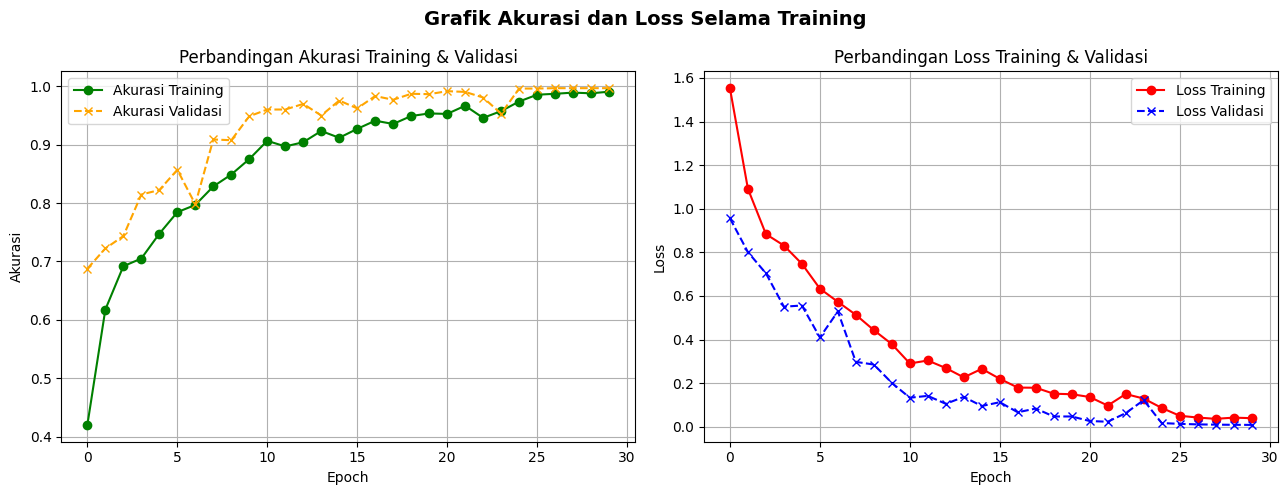

In [9]:
# Visualisasi hasil pelatihan model
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13, 5))

# Grafik Akurasi
axes[0].plot(history.history['accuracy'], color='green', linestyle='-', marker='o', label='Akurasi Training')
axes[0].plot(history.history['val_accuracy'], color='orange', linestyle='--', marker='x', label='Akurasi Validasi')
axes[0].set_title('Perbandingan Akurasi Training & Validasi')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Akurasi')
axes[0].grid(True)
axes[0].legend()

# Grafik Loss
axes[1].plot(history.history['loss'], color='red', linestyle='-', marker='o', label='Loss Training')
axes[1].plot(history.history['val_loss'], color='blue', linestyle='--', marker='x', label='Loss Validasi')
axes[1].set_title('Perbandingan Loss Training & Validasi')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].grid(True)
axes[1].legend()

plt.suptitle('Grafik Akurasi dan Loss Selama Training', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## Konversi Model

In [10]:
# Direktori menyimpan model
saved_model_dir = '/content/saved_model_weather'
os.makedirs(saved_model_dir, exist_ok=True)

# Export SavedModel
model.export(saved_model_dir)

# Save ke TFLite
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

with open('/content/weather_model.tflite', 'wb') as f:
    f.write(tflite_model)

# Save ke TFJS
tfjs_target_dir = '/content/tfjs_model_weather'
os.makedirs(tfjs_target_dir, exist_ok=True)
tfjs.converters.save_keras_model(model, tfjs_target_dir)

print("Model saved successfully in SavedModel, TFLite, and TFJS formats.")

Saved artifact at '/content/saved_model_weather'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 8), dtype=tf.float32, name=None)
Captures:
  140034896316752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140034896319056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140034896318864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140034896319824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140034896320016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140034896320592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140034896319632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140034896320208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140034896320400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140034896321552: TensorSpec(shape=(), dtype=tf.resource, name=None)


failed to lookup keras version from the file,
    this is likely a weight only file
Model saved successfully in SavedModel, TFLite, and TFJS formats.


## Inference (Optional)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 532ms/step


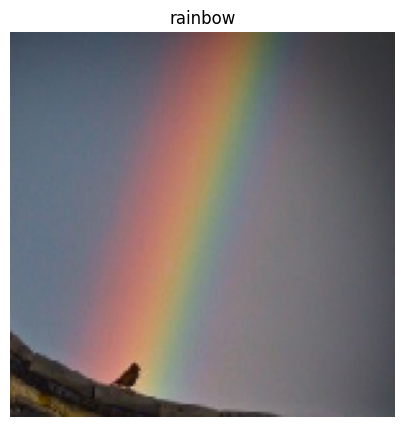

In [12]:
sample_img, label = next(test_gen)
pred = model.predict(sample_img)

class_indices = test_gen.class_indices
idx_to_class = {v: k for k, v in class_indices.items()}

predicted_classes = np.argmax(pred, axis=1)

chosen_idx = random.randint(0, len(predicted_classes) - 1)

# Tampilkan gambar
plt.figure(figsize=(5, 5))
plt.imshow(sample_img[chosen_idx])
plt.axis('off')
pred_label = idx_to_class[predicted_classes[chosen_idx]]
plt.title(pred_label, fontsize=12)
plt.show()

In [13]:
!pip freeze > requirements.txt